
# Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
!pip install albumentations==0.4.6

In [2]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [7]:
mean = m/255
sdev = s/255

In [8]:
SEED = 101
BATCH = 64

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
# # transforms
# train_transforms = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean=mean, std=sdev)
#                                        ])

# test_transforms = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean, std=sdev)])

# # data sets with transforms
# train_set = torchvision.datasets.CIFAR10(root='./cifar-10', download=True, train=True, transform=train_transforms)

# test_set = torchvision.datasets.CIFAR10('./cifar-10', train=False, download=True, transform=test_transforms)


# # data loaders on data sets
# train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

# from __future__ import print_function
# channel_means = (0.49139968, 0.48215841, 0.44653091)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# def unnormalize(img):
#   img = img.numpy().astype(dtype=np.float32)
  
#   for i in range(img.shape[0]):
#     img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
#   return np.transpose(img, (1,2,0))
#   #return np.transpose(img, (1, 2, 0))

# %matplotlib inline
# import matplotlib.pyplot as plt
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# num_classes = 10
# # display 10 images from each category. 
# class_names = ['airplane','automobile','bird','cat','deer',
#                'dog','frog','horse','ship','truck']
# r, c = 10, 11
# n = 5
# fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.04, wspace=0.04)
# for i in range(num_classes):
#     idx = np.random.choice(np.where(labels[:]==i)[0], n)
#     ax = plt.subplot(r, c, i*c+1)
#     ax.text(-1.5, 0.5, class_names[i], fontsize=14)
#     plt.axis('off')
#     for j in range(1, n+1):
#       plt.subplot(r, c, i*c+j+1)
#       plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
#       plt.axis('off')
# plt.show()

In [10]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [11]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [12]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [13]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=30,p=0.20),
                                A.CoarseDropout(max_holes=1, p=0.15, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                            ToTensor()
                                    ])


In [14]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

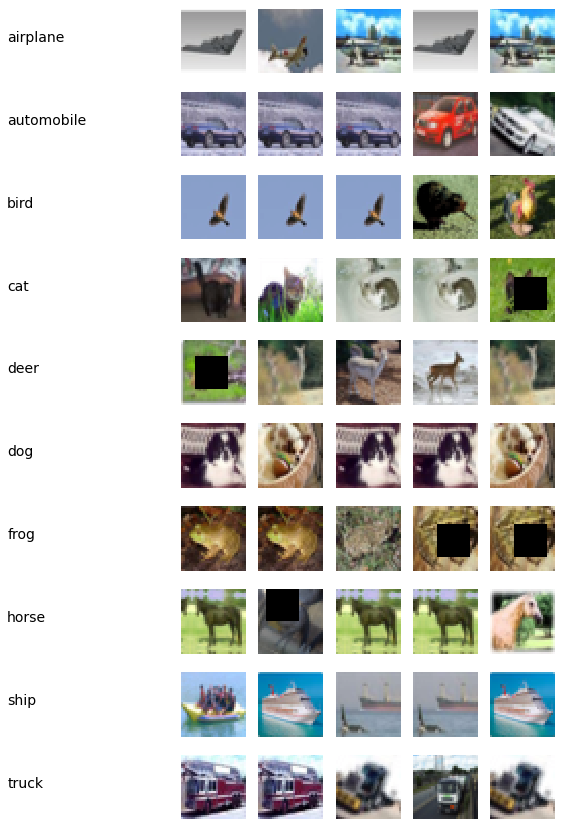

In [15]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Code 9: 

In [16]:
# class Net9(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.block1 = nn.Sequential(
#             cv(3, 16, 3, padding=1),
#             relu(),
#             bn(16),
#             cv(16, 32, 3, dilation=2, groups=8, padding=1),
#             relu(),
#             bn(32),
#             nn.Dropout2d(0.07)
           
#         )

#         self.block2 = nn.Sequential(
#             cv(32, 64, 3, padding=1, dilation=1, groups=8),
#             relu(),
#             bn(64),
#             cv(64, 80, 3, dilation=1, padding=0, groups=4),
#             relu(),
#             bn(80),
#             cv(80, 64, 1),
#             relu(),
#             bn(64),
#             cv(64, 64, 3, padding=1, dilation=2),
#             relu(),
#             bn(64),
#             nn.Dropout2d(0.09)
#             # Conv2d(32, 32, 3, padding=2, dilation=2, stride=2)
#         )

#         self.block3a = nn.Sequential(
#             cv(64, 128, 3, dilation=1, groups=32, stride=1),
#             relu(),
#             bn(128),
#             cv(128, 160, 3, groups=16, dilation=1, padding=1),
#             relu(),
#             bn(160))
        
#         self.block3b = nn.Sequential(
#             cv(160, 64, 1),
#             cv(64, 64, 3, padding=1, groups=16),
#             relu(),
#             bn(64),
#             cv(64, 96, 3, padding=2, dilation=2, stride=2),
#             relu(),
#             bn(96),
#             nn.Dropout2d(0.09)
#         )

#         self.block4 = nn.Sequential(
#             cv(96, 224, 3, padding=1, groups=16, stride=1, dilation=2), # grps 32 changed to 64
#             bn(224),
#             cv(224, 64, 1),
#             bn(64),
#             relu(),
#             nn.Dropout2d(0.05),
#             cv(64, 64, 3, groups=64, padding=1), # depthwise (a)
#             cv(64, 32, 1), # pointwise for preceding depthwise (b)
#             bn(32),
#             relu(),
#             cv(32, 32, 3, dilation=1, groups=16),
#             relu(),
#             bn(32),
#             cv(32, 10, 1),
#             nn.AdaptiveAvgPool2d(1)
#             # cv(10, 10, 1)
#         )
    
        
#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3a(x)
#         x = self.block3b(x)
#         x = self.block4(x)
        
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


# model = Net9().to(device)
# summary(model, (3, 32, 32))

In [17]:
# optimizer = optim.SGD(model.parameters(), lr=0.0159, momentum=0.9, nesterov=True) # lr changed
# step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.71) # gamma changed from previous value

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=step_lr)

In [18]:
# plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
#             test_losses=test_losses,test_accuracy=test_accuracy)

# Code 10

In [19]:
class Net10(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 16, 1),
            relu(),
            bn(16),
            cv(16, 24, 3, dilation=1, groups=1, padding=1),
            relu(),
            bn(24),
            cv(24, 24, 1),
            relu(),
            bn(24),
            nn.Dropout2d(0.03)
        )

        self.block2 = nn.Sequential(
            cv(24, 32, 3, padding=1, dilation=1, groups=8),
            relu(),
            bn(32),
            cv(32, 32, 1),
            relu(),
            bn(32),
            cv(32, 64, 3, dilation=1, padding=1, groups=32),
            relu(),
            bn(64),
            cv(64, 48, 1),
            relu(),
            bn(48),
            cv(48, 64, 3, padding=1, dilation=2, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.05)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=1, groups=16, stride=1),
            relu(),
            bn(64),
            cv(64, 128, 3, groups=16, dilation=1, padding=1),
            relu(),
            bn(128),
            cv(128, 64, 1),
            relu(),
            bn(64),
            cv(64, 96, 3, padding=1, groups=16),
            relu(),
            bn(96),
            cv(96, 64, 1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            cv(64, 64, 1),
            relu(),
            bn(64),
            nn.Dropout2d(0.05)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=1, groups=32, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),
            bn(64),
            relu(),
            nn.Dropout2d(0.02),
            cv(64, 64, 3, groups=64, padding=1, dilation=2), # depthwise (a)
            cv(64, 32, 1), # pointwise for preceding depthwise (b)
            bn(32),
            relu(),
            cv(32, 48, 3, dilation=2, groups=16),
            relu(),
            bn(48),
            cv(48, 10, 1, stride=2),
            relu(),
            bn(10),
            nn.AdaptiveAvgPool2d(1)
            #cv(10, 10, 1)
        )
    
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = Net10().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]             256
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 24, 32, 32]           3,456
              ReLU-8           [-1, 24, 32, 32]               0
       BatchNorm2d-9           [-1, 24, 32, 32]              48
           Conv2d-10           [-1, 24, 32, 32]             576
             ReLU-11           [-1, 24, 32, 32]               0
      BatchNorm2d-12           [-1, 24, 32, 32]              48
        Dropout2d-13           [-1, 24, 32, 32]               0
           Conv2d-14           [-1, 32,

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.013, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.81)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model, train_loader, optimizer, device, epochs=12, test=True, test_loader=test_loader,scheduler=step_lr)

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:29<00:00, 26.20it/s]



			Last LR --> [0.013]

			Train metrics: accuracy: 17870/50000 (35.7400%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 1.4404, accuracy: 4798/10000 (47.98000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:28<00:00, 27.00it/s]



			Last LR --> [0.013]

			Train metrics: accuracy: 23097/50000 (46.1940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 1.4441, accuracy: 4831/10000 (48.31000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.10it/s]



			Last LR --> [0.01053]

			Train metrics: accuracy: 26199/50000 (52.3980%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1891, accuracy: 5735/10000 (57.35000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:29<00:00, 26.92it/s]



			Last LR --> [0.01053]

			Train metrics: accuracy: 28085/50000 (56.1700%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1091, accuracy: 6067/10000 (60.67000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:29<00:00, 26.94it/s]



			Last LR --> [0.0085293]

			Train metrics: accuracy: 30101/50000 (60.2020%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0222, accuracy: 6375/10000 (63.75000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:29<00:00, 26.95it/s]



			Last LR --> [0.0085293]

			Train metrics: accuracy: 31402/50000 (62.8040%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9469, accuracy: 6675/10000 (66.75000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:29<00:00, 26.88it/s]



			Last LR --> [0.006908733]

			Train metrics: accuracy: 32865/50000 (65.7300%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8637, accuracy: 6956/10000 (69.56000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:29<00:00, 26.69it/s]



			Last LR --> [0.006908733]

			Train metrics: accuracy: 33633/50000 (67.2660%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8588, accuracy: 7078/10000 (70.78000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.05it/s]



			Last LR --> [0.005596073730000001]

			Train metrics: accuracy: 34625/50000 (69.2500%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8328, accuracy: 7134/10000 (71.34000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:28<00:00, 27.01it/s]



			Last LR --> [0.005596073730000001]

			Train metrics: accuracy: 35241/50000 (70.4820%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7605, accuracy: 7417/10000 (74.17000%)


 epoch num ================================= 11


100%|██████████| 782/782 [00:29<00:00, 26.95it/s]



			Last LR --> [0.004532819721300001]

			Train metrics: accuracy: 35975/50000 (71.9500%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7317, accuracy: 7443/10000 (74.43000%)


 epoch num ================================= 12


100%|██████████| 782/782 [00:29<00:00, 26.82it/s]



			Last LR --> [0.004532819721300001]

			Train metrics: accuracy: 36547/50000 (73.0940%)



	Test metrics: average loss: 0.7173, accuracy: 7545/10000 (75.45000%)



In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.0019, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=15, test=True, test_loader=test_loader,scheduler=step_lr)

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:30<00:00, 25.96it/s]



			Last LR --> [0.0019]

			Train metrics: accuracy: 32548/50000 (65.0960%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8093, accuracy: 7445/10000 (74.45000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:29<00:00, 26.85it/s]



			Last LR --> [0.0019]

			Train metrics: accuracy: 36642/50000 (73.2840%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6885, accuracy: 7619/10000 (76.19000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:29<00:00, 26.75it/s]



			Last LR --> [0.001539]

			Train metrics: accuracy: 37514/50000 (75.0280%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6618, accuracy: 7689/10000 (76.89000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:29<00:00, 26.72it/s]



			Last LR --> [0.001539]

			Train metrics: accuracy: 38020/50000 (76.0400%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6530, accuracy: 7748/10000 (77.48000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:29<00:00, 26.72it/s]



			Last LR --> [0.0012465900000000001]

			Train metrics: accuracy: 38272/50000 (76.5440%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6431, accuracy: 7807/10000 (78.07000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 26.98it/s]



			Last LR --> [0.0012465900000000001]

			Train metrics: accuracy: 38432/50000 (76.8640%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6427, accuracy: 7803/10000 (78.03000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 27.22it/s]



			Last LR --> [0.0010097379000000002]

			Train metrics: accuracy: 38762/50000 (77.5240%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6325, accuracy: 7839/10000 (78.39000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:28<00:00, 27.14it/s]



			Last LR --> [0.0010097379000000002]

			Train metrics: accuracy: 38804/50000 (77.6080%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6270, accuracy: 7872/10000 (78.72000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.19it/s]



			Last LR --> [0.0008178876990000002]

			Train metrics: accuracy: 39045/50000 (78.0900%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6248, accuracy: 7846/10000 (78.46000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]



			Last LR --> [0.0008178876990000002]

			Train metrics: accuracy: 39118/50000 (78.2360%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6199, accuracy: 7879/10000 (78.79000%)


 epoch num ================================= 11


100%|██████████| 782/782 [00:28<00:00, 27.22it/s]



			Last LR --> [0.0006624890361900003]

			Train metrics: accuracy: 39413/50000 (78.8260%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6202, accuracy: 7863/10000 (78.63000%)


 epoch num ================================= 12


100%|██████████| 782/782 [00:28<00:00, 27.07it/s]



			Last LR --> [0.0006624890361900003]

			Train metrics: accuracy: 39516/50000 (79.0320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6190, accuracy: 7913/10000 (79.13000%)


 epoch num ================================= 13


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]



			Last LR --> [0.0005366161193139003]

			Train metrics: accuracy: 39680/50000 (79.3600%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6126, accuracy: 7915/10000 (79.15000%)


 epoch num ================================= 14


100%|██████████| 782/782 [00:28<00:00, 27.22it/s]



			Last LR --> [0.0005366161193139003]

			Train metrics: accuracy: 39817/50000 (79.6340%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6187, accuracy: 7905/10000 (79.05000%)


 epoch num ================================= 15


100%|██████████| 782/782 [00:28<00:00, 27.22it/s]



			Last LR --> [0.00043465905664425927]

			Train metrics: accuracy: 39967/50000 (79.9340%)



	Test metrics: average loss: 0.6143, accuracy: 7913/10000 (79.13000%)



In [35]:
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=step_lr)

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:30<00:00, 26.04it/s]



			Last LR --> [0.015]

			Train metrics: accuracy: 34353/50000 (68.7060%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7077, accuracy: 7609/10000 (76.09000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:28<00:00, 27.14it/s]



			Last LR --> [0.012150000000000001]

			Train metrics: accuracy: 36124/50000 (72.2480%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7511, accuracy: 7393/10000 (73.93000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.19it/s]



			Last LR --> [0.009841500000000001]

			Train metrics: accuracy: 36997/50000 (73.9940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6989, accuracy: 7561/10000 (75.61000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]



			Last LR --> [0.007971615000000001]

			Train metrics: accuracy: 37737/50000 (75.4740%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6912, accuracy: 7637/10000 (76.37000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]



			Last LR --> [0.006457008150000001]

			Train metrics: accuracy: 38374/50000 (76.7480%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6607, accuracy: 7728/10000 (77.28000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 26.98it/s]



			Last LR --> [0.005230176601500001]

			Train metrics: accuracy: 38910/50000 (77.8200%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6256, accuracy: 7915/10000 (79.15000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 26.98it/s]



			Last LR --> [0.004236443047215001]

			Train metrics: accuracy: 39413/50000 (78.8260%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5900, accuracy: 7991/10000 (79.91000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:28<00:00, 27.05it/s]



			Last LR --> [0.003431518868244151]

			Train metrics: accuracy: 39997/50000 (79.9940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5839, accuracy: 8030/10000 (80.30000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.13it/s]



			Last LR --> [0.0027795302832777625]

			Train metrics: accuracy: 40352/50000 (80.7040%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5858, accuracy: 8053/10000 (80.53000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:28<00:00, 27.24it/s]



			Last LR --> [0.002251419529454988]

			Train metrics: accuracy: 40521/50000 (81.0420%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5601, accuracy: 8135/10000 (81.35000%)


 epoch num ================================= 11


100%|██████████| 782/782 [00:28<00:00, 27.10it/s]



			Last LR --> [0.0018236498188585403]

			Train metrics: accuracy: 40767/50000 (81.5340%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5720, accuracy: 8091/10000 (80.91000%)


 epoch num ================================= 12


100%|██████████| 782/782 [00:28<00:00, 27.18it/s]



			Last LR --> [0.0014771563532754177]

			Train metrics: accuracy: 40932/50000 (81.8640%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5543, accuracy: 8157/10000 (81.57000%)


 epoch num ================================= 13


100%|██████████| 782/782 [00:28<00:00, 27.20it/s]



			Last LR --> [0.0011964966461530883]

			Train metrics: accuracy: 41379/50000 (82.7580%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5632, accuracy: 8161/10000 (81.61000%)


 epoch num ================================= 14


100%|██████████| 782/782 [00:28<00:00, 27.12it/s]



			Last LR --> [0.0009691622833840016]

			Train metrics: accuracy: 41579/50000 (83.1580%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5575, accuracy: 8181/10000 (81.81000%)


 epoch num ================================= 15


100%|██████████| 782/782 [00:28<00:00, 27.27it/s]



			Last LR --> [0.0007850214495410413]

			Train metrics: accuracy: 41722/50000 (83.4440%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5525, accuracy: 8176/10000 (81.76000%)


 epoch num ================================= 16


100%|██████████| 782/782 [00:28<00:00, 27.16it/s]



			Last LR --> [0.0006358673741282435]

			Train metrics: accuracy: 41805/50000 (83.6100%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5487, accuracy: 8200/10000 (82.00000%)


 epoch num ================================= 17


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]



			Last LR --> [0.0005150525730438772]

			Train metrics: accuracy: 41916/50000 (83.8320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5540, accuracy: 8179/10000 (81.79000%)


 epoch num ================================= 18


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]



			Last LR --> [0.0004171925841655406]

			Train metrics: accuracy: 41940/50000 (83.8800%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5537, accuracy: 8184/10000 (81.84000%)


 epoch num ================================= 19


100%|██████████| 782/782 [00:28<00:00, 27.29it/s]



			Last LR --> [0.0003379259931740879]

			Train metrics: accuracy: 42019/50000 (84.0380%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5519, accuracy: 8185/10000 (81.85000%)


 epoch num ================================= 20


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]



			Last LR --> [0.0002737200544710112]

			Train metrics: accuracy: 42119/50000 (84.2380%)



	Test metrics: average loss: 0.5476, accuracy: 8193/10000 (81.93000%)



In [36]:
torch.save(model, "./s7_exp_2.pth")

In [37]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=10, test=True, test_loader=test_loader,scheduler=None)

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:30<00:00, 25.74it/s]


			Train metrics: accuracy: 37818/50000 (75.6360%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5760, accuracy: 8149/10000 (81.49000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:29<00:00, 26.54it/s]


			Train metrics: accuracy: 41154/50000 (82.3080%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5368, accuracy: 8194/10000 (81.94000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:29<00:00, 26.88it/s]


			Train metrics: accuracy: 41486/50000 (82.9720%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5434, accuracy: 8192/10000 (81.92000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


			Train metrics: accuracy: 41665/50000 (83.3300%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5424, accuracy: 8182/10000 (81.82000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:29<00:00, 26.80it/s]


			Train metrics: accuracy: 41705/50000 (83.4100%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5434, accuracy: 8199/10000 (81.99000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:29<00:00, 26.80it/s]


			Train metrics: accuracy: 41882/50000 (83.7640%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5438, accuracy: 8187/10000 (81.87000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 27.06it/s]


			Train metrics: accuracy: 41742/50000 (83.4840%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5409, accuracy: 8202/10000 (82.02000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:29<00:00, 26.92it/s]


			Train metrics: accuracy: 42048/50000 (84.0960%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5484, accuracy: 8184/10000 (81.84000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.00it/s]


			Train metrics: accuracy: 42041/50000 (84.0820%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5465, accuracy: 8197/10000 (81.97000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:29<00:00, 26.88it/s]


			Train metrics: accuracy: 41992/50000 (83.9840%)



	Test metrics: average loss: 0.5498, accuracy: 8191/10000 (81.91000%)



In [38]:
torch.save(model, "./s7_exp_2.pth")

In [39]:
optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=10, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:29<00:00, 26.17it/s]


			Train metrics: accuracy: 38572/50000 (77.1440%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5507, accuracy: 8179/10000 (81.79000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:29<00:00, 26.88it/s]


			Train metrics: accuracy: 41713/50000 (83.4260%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5315, accuracy: 8198/10000 (81.98000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.06it/s]


			Train metrics: accuracy: 41947/50000 (83.8940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5298, accuracy: 8220/10000 (82.20000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:29<00:00, 26.78it/s]


			Train metrics: accuracy: 42079/50000 (84.1580%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5279, accuracy: 8215/10000 (82.15000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:28<00:00, 27.30it/s]


			Train metrics: accuracy: 42260/50000 (84.5200%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5347, accuracy: 8231/10000 (82.31000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 27.43it/s]


			Train metrics: accuracy: 42382/50000 (84.7640%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5387, accuracy: 8220/10000 (82.20000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 27.40it/s]


			Train metrics: accuracy: 42417/50000 (84.8340%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5392, accuracy: 8237/10000 (82.37000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:28<00:00, 27.43it/s]


			Train metrics: accuracy: 42456/50000 (84.9120%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5361, accuracy: 8224/10000 (82.24000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.44it/s]


			Train metrics: accuracy: 42508/50000 (85.0160%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5368, accuracy: 8227/10000 (82.27000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:28<00:00, 27.31it/s]


			Train metrics: accuracy: 42476/50000 (84.9520%)



	Test metrics: average loss: 0.5407, accuracy: 8215/10000 (82.15000%)



In [40]:
torch.save(model, "./s7_exp_2.pth")

In [41]:
optimizer = optim.SGD(model.parameters(), lr=0.0009, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=6, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:29<00:00, 26.47it/s]


			Train metrics: accuracy: 38689/50000 (77.3780%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5373, accuracy: 8222/10000 (82.22000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:28<00:00, 27.28it/s]


			Train metrics: accuracy: 42040/50000 (84.0800%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5259, accuracy: 8230/10000 (82.30000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.31it/s]


			Train metrics: accuracy: 42233/50000 (84.4660%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5310, accuracy: 8270/10000 (82.70000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:28<00:00, 27.31it/s]


			Train metrics: accuracy: 42380/50000 (84.7600%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5366, accuracy: 8240/10000 (82.40000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:28<00:00, 27.43it/s]


			Train metrics: accuracy: 42567/50000 (85.1340%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5335, accuracy: 8233/10000 (82.33000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 27.04it/s]


			Train metrics: accuracy: 42705/50000 (85.4100%)



	Test metrics: average loss: 0.5365, accuracy: 8215/10000 (82.15000%)



In [42]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=6, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:29<00:00, 26.10it/s]


			Train metrics: accuracy: 38716/50000 (77.4320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5462, accuracy: 8191/10000 (81.91000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:28<00:00, 27.17it/s]


			Train metrics: accuracy: 41491/50000 (82.9820%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5596, accuracy: 8174/10000 (81.74000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


			Train metrics: accuracy: 41505/50000 (83.0100%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5472, accuracy: 8160/10000 (81.60000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:29<00:00, 26.94it/s]


			Train metrics: accuracy: 41647/50000 (83.2940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6013, accuracy: 8042/10000 (80.42000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]


			Train metrics: accuracy: 41672/50000 (83.3440%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5601, accuracy: 8138/10000 (81.38000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:29<00:00, 26.92it/s]


			Train metrics: accuracy: 41735/50000 (83.4700%)



	Test metrics: average loss: 0.5479, accuracy: 8190/10000 (81.90000%)



In [43]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.69)


train_eval_model(model, train_loader, optimizer, device, epochs=15, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:30<00:00, 25.76it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 39023/50000 (78.0460%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5233, accuracy: 8239/10000 (82.39000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:29<00:00, 26.88it/s]



			Last LR --> [0.00069]

			Train metrics: accuracy: 42629/50000 (85.2580%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5127, accuracy: 8262/10000 (82.62000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.17it/s]



			Last LR --> [0.0004760999999999999]

			Train metrics: accuracy: 42781/50000 (85.5620%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5168, accuracy: 8276/10000 (82.76000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:28<00:00, 27.10it/s]



			Last LR --> [0.00032850899999999994]

			Train metrics: accuracy: 42977/50000 (85.9540%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5179, accuracy: 8271/10000 (82.71000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:29<00:00, 26.95it/s]



			Last LR --> [0.00022667120999999993]

			Train metrics: accuracy: 43072/50000 (86.1440%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5165, accuracy: 8278/10000 (82.78000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 27.20it/s]



			Last LR --> [0.00015640313489999994]

			Train metrics: accuracy: 43046/50000 (86.0920%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5167, accuracy: 8289/10000 (82.89000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 27.28it/s]



			Last LR --> [0.00010791816308099995]

			Train metrics: accuracy: 43137/50000 (86.2740%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5181, accuracy: 8286/10000 (82.86000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:28<00:00, 27.22it/s]



			Last LR --> [7.446353252588996e-05]

			Train metrics: accuracy: 43238/50000 (86.4760%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5200, accuracy: 8291/10000 (82.91000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:28<00:00, 27.27it/s]



			Last LR --> [5.137983744286407e-05]

			Train metrics: accuracy: 43225/50000 (86.4500%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5184, accuracy: 8301/10000 (83.01000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:28<00:00, 27.21it/s]



			Last LR --> [3.545208783557621e-05]

			Train metrics: accuracy: 43226/50000 (86.4520%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5188, accuracy: 8295/10000 (82.95000%)


 epoch num ================================= 11


100%|██████████| 782/782 [00:28<00:00, 27.24it/s]



			Last LR --> [2.446194060654758e-05]

			Train metrics: accuracy: 43166/50000 (86.3320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5181, accuracy: 8296/10000 (82.96000%)


 epoch num ================================= 12


100%|██████████| 782/782 [00:28<00:00, 27.26it/s]



			Last LR --> [1.687873901851783e-05]

			Train metrics: accuracy: 43130/50000 (86.2600%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5183, accuracy: 8295/10000 (82.95000%)


 epoch num ================================= 13


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]



			Last LR --> [1.1646329922777301e-05]

			Train metrics: accuracy: 43375/50000 (86.7500%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5184, accuracy: 8298/10000 (82.98000%)


 epoch num ================================= 14


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]



			Last LR --> [8.035967646716337e-06]

			Train metrics: accuracy: 43298/50000 (86.5960%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5183, accuracy: 8299/10000 (82.99000%)


 epoch num ================================= 15


100%|██████████| 782/782 [00:28<00:00, 27.21it/s]



			Last LR --> [5.544817676234272e-06]

			Train metrics: accuracy: 43321/50000 (86.6420%)



	Test metrics: average loss: 0.5184, accuracy: 8297/10000 (82.97000%)



In [45]:
torch.save(model, "./s7_exp_2.pth")

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.71)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/782 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 782/782 [00:29<00:00, 26.66it/s]



			Last LR --> [0.005]

			Train metrics: accuracy: 38980/50000 (77.9600%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5351, accuracy: 8204/10000 (82.04000%)


 epoch num ================================= 2


100%|██████████| 782/782 [00:28<00:00, 27.30it/s]



			Last LR --> [0.0035499999999999998]

			Train metrics: accuracy: 41619/50000 (83.2380%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5554, accuracy: 8165/10000 (81.65000%)


 epoch num ================================= 3


100%|██████████| 782/782 [00:28<00:00, 27.35it/s]



			Last LR --> [0.0025204999999999997]

			Train metrics: accuracy: 42100/50000 (84.2000%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5408, accuracy: 8206/10000 (82.06000%)


 epoch num ================================= 4


100%|██████████| 782/782 [00:28<00:00, 27.28it/s]



			Last LR --> [0.0017895549999999997]

			Train metrics: accuracy: 42533/50000 (85.0660%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5323, accuracy: 8243/10000 (82.43000%)


 epoch num ================================= 5


100%|██████████| 782/782 [00:28<00:00, 27.23it/s]



			Last LR --> [0.0012705840499999997]

			Train metrics: accuracy: 42756/50000 (85.5120%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5463, accuracy: 8227/10000 (82.27000%)


 epoch num ================================= 6


100%|██████████| 782/782 [00:28<00:00, 27.23it/s]



			Last LR --> [0.0009021146754999998]

			Train metrics: accuracy: 43203/50000 (86.4060%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5211, accuracy: 8304/10000 (83.04000%)


 epoch num ================================= 7


100%|██████████| 782/782 [00:28<00:00, 27.13it/s]



			Last LR --> [0.0006405014196049998]

			Train metrics: accuracy: 43359/50000 (86.7180%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5302, accuracy: 8271/10000 (82.71000%)


 epoch num ================================= 8


100%|██████████| 782/782 [00:28<00:00, 27.09it/s]



			Last LR --> [0.0004547560079195498]

			Train metrics: accuracy: 43433/50000 (86.8660%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5235, accuracy: 8293/10000 (82.93000%)


 epoch num ================================= 9


100%|██████████| 782/782 [00:29<00:00, 26.53it/s]



			Last LR --> [0.00032287676562288035]

			Train metrics: accuracy: 43508/50000 (87.0160%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5272, accuracy: 8298/10000 (82.98000%)


 epoch num ================================= 10


100%|██████████| 782/782 [00:29<00:00, 26.53it/s]



			Last LR --> [0.00022924250359224502]

			Train metrics: accuracy: 43663/50000 (87.3260%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5262, accuracy: 8292/10000 (82.92000%)


 epoch num ================================= 11


100%|██████████| 782/782 [00:28<00:00, 27.14it/s]



			Last LR --> [0.00016276217755049397]

			Train metrics: accuracy: 43567/50000 (87.1340%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5246, accuracy: 8303/10000 (83.03000%)


 epoch num ================================= 12


100%|██████████| 782/782 [00:28<00:00, 27.17it/s]



			Last LR --> [0.00011556114606085071]

			Train metrics: accuracy: 43694/50000 (87.3880%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5257, accuracy: 8306/10000 (83.06000%)


 epoch num ================================= 13


100%|██████████| 782/782 [00:29<00:00, 26.91it/s]



			Last LR --> [8.2048413703204e-05]

			Train metrics: accuracy: 43697/50000 (87.3940%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5262, accuracy: 8303/10000 (83.03000%)


 epoch num ================================= 14


100%|██████████| 782/782 [00:28<00:00, 27.13it/s]



			Last LR --> [5.825437372927484e-05]

			Train metrics: accuracy: 43704/50000 (87.4080%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5259, accuracy: 8308/10000 (83.08000%)


 epoch num ================================= 15


100%|██████████| 782/782 [00:28<00:00, 27.34it/s]



			Last LR --> [4.1360605347785134e-05]

			Train metrics: accuracy: 43712/50000 (87.4240%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5253, accuracy: 8311/10000 (83.11000%)


 epoch num ================================= 16


100%|██████████| 782/782 [00:28<00:00, 27.06it/s]



			Last LR --> [2.9366029796927444e-05]

			Train metrics: accuracy: 43766/50000 (87.5320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5261, accuracy: 8310/10000 (83.10000%)


 epoch num ================================= 17


100%|██████████| 782/782 [00:28<00:00, 27.27it/s]



			Last LR --> [2.0849881155818483e-05]

			Train metrics: accuracy: 43744/50000 (87.4880%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5255, accuracy: 8315/10000 (83.15000%)


 epoch num ================================= 18


100%|██████████| 782/782 [00:28<00:00, 27.32it/s]



			Last LR --> [1.4803415620631122e-05]

			Train metrics: accuracy: 43661/50000 (87.3220%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5254, accuracy: 8319/10000 (83.19000%)


 epoch num ================================= 19


100%|██████████| 782/782 [00:28<00:00, 27.36it/s]



			Last LR --> [1.0510425090648096e-05]

			Train metrics: accuracy: 43850/50000 (87.7000%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5245, accuracy: 8320/10000 (83.20000%)


 epoch num ================================= 20


100%|██████████| 782/782 [00:28<00:00, 27.21it/s]



			Last LR --> [7.462401814360147e-06]

			Train metrics: accuracy: 43746/50000 (87.4920%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5252, accuracy: 8318/10000 (83.18000%)


 epoch num ================================= 21


100%|██████████| 782/782 [00:28<00:00, 27.07it/s]



			Last LR --> [5.298305288195705e-06]

			Train metrics: accuracy: 43646/50000 (87.2920%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5255, accuracy: 8314/10000 (83.14000%)


 epoch num ================================= 22


100%|██████████| 782/782 [00:29<00:00, 26.62it/s]



			Last LR --> [3.7617967546189503e-06]

			Train metrics: accuracy: 43715/50000 (87.4300%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5251, accuracy: 8323/10000 (83.23000%)


 epoch num ================================= 23


100%|██████████| 782/782 [00:28<00:00, 27.26it/s]



			Last LR --> [2.6708756957794547e-06]

			Train metrics: accuracy: 43752/50000 (87.5040%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5253, accuracy: 8318/10000 (83.18000%)


 epoch num ================================= 24


100%|██████████| 782/782 [00:28<00:00, 27.08it/s]



			Last LR --> [1.8963217440034128e-06]

			Train metrics: accuracy: 43800/50000 (87.6000%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5253, accuracy: 8319/10000 (83.19000%)


 epoch num ================================= 25


100%|██████████| 782/782 [00:28<00:00, 27.11it/s]



			Last LR --> [1.346388438242423e-06]

			Train metrics: accuracy: 43639/50000 (87.2780%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5252, accuracy: 8322/10000 (83.22000%)


 epoch num ================================= 26


100%|██████████| 782/782 [00:28<00:00, 27.30it/s]



			Last LR --> [9.559357911521203e-07]

			Train metrics: accuracy: 43778/50000 (87.5560%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5252, accuracy: 8322/10000 (83.22000%)


 epoch num ================================= 27


100%|██████████| 782/782 [00:28<00:00, 27.25it/s]



			Last LR --> [6.787144117180054e-07]

			Train metrics: accuracy: 43664/50000 (87.3280%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5252, accuracy: 8323/10000 (83.23000%)


 epoch num ================================= 28


100%|██████████| 782/782 [00:28<00:00, 27.18it/s]



			Last LR --> [4.818872323197838e-07]

			Train metrics: accuracy: 43666/50000 (87.3320%)



  0%|          | 0/782 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5251, accuracy: 8324/10000 (83.24000%)


 epoch num ================================= 29


 64%|██████▍   | 502/782 [00:18<00:10, 27.45it/s]

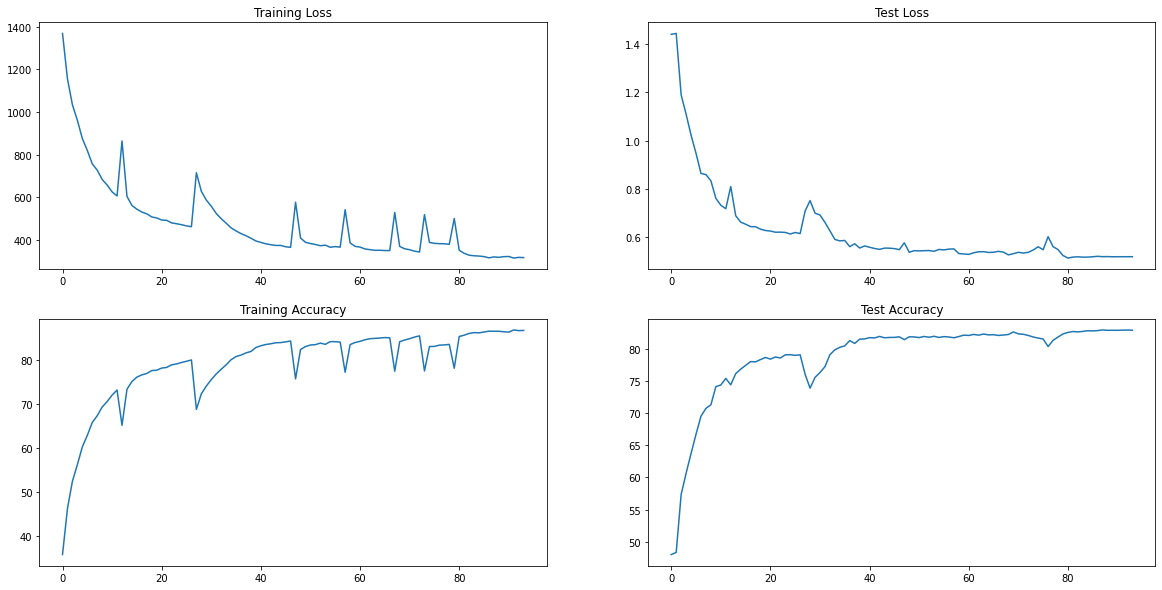

In [44]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)

# Model previous run as per Model 1: Overfitting

In [23]:
# class Net2(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.block1 = nn.Sequential(
#             Conv2d(3, 32, 3, padding=1, stride=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 3, padding=0, stride=1, groups=16),
#             nn.BatchNorm2d(64),
#             nn.ReLU()
#         )

#         self.block2 = nn.Sequential(
#             nn.Conv2d(64, 80, 3, padding=1, stride=2),
#             nn.BatchNorm2d(80),
#             nn.ReLU(),
#             nn.Conv2d(80, 150, 3, padding=0, stride=1, dilation=2),
#             nn.BatchNorm2d(150),
#             nn.ReLU()
#             # nn.MaxPool2d(2)
#         )

#         self.block3 = nn.Sequential(
#             nn.Conv2d(150, 256, 3, padding=0, stride=1, dilation=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU()
#         )

#         self.block4 = nn.Sequential(
#             nn.Conv2d(256, 10, 1),
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(10, 10, 1)
#         )

#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


In [24]:
# model = Net().to(device)
# summary(model, (3, 32, 32))

In [25]:
# optimizer = optim.SGD(model.parameters(), lr=0.0061, momentum=0.9) #0.0031
# scheduler = StepLR(optimizer=optimizer, step_size=4, gamma=0.74)

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=scheduler)

In [26]:
# fig, axs = plt.subplots(2,2,figsize=(20,10))
# axs[0, 0].plot(train_losses)
# axs[0, 0].set_title("Training Loss")
# axs[1, 0].plot(train_accuracy)
# axs[1, 0].set_title("Training Accuracy")
# axs[0, 1].plot(test_losses)
# axs[0, 1].set_title("Test Loss")
# axs[1, 1].plot(test_accuracy)
# axs[1, 1].set_title("Test Accuracy")

In [27]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.block1 = nn.Sequential(
#             nn.Conv2d(3, 64, 3, padding=0, stride=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             # nn.Conv2d(64, 40, 1, padding=0, bias=False),
#             # nn.BatchNorm2d(40),
#             # nn.ReLU(),
#             nn.Conv2d(64, 64, 3, padding=0, stride=1, groups=64),
#             nn.Conv2d(64, 32, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU()
#         )

#         self.block2 = nn.Sequential(
#             nn.Conv2d(32, 128, 3, padding=0, stride=1, groups=8, bias=False),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, 3, padding=0, groups=8, bias=False),
#             nn.Conv2d(256, 96, 1, bias=False),
#             nn.BatchNorm2d(96),
#             nn.ReLU()
#         )

#         self.block3 = nn.Sequential(
#             nn.Conv2d(96, 256, 3, padding=0, stride=1, groups=16, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, 3, padding=0, groups=8, bias=False),
#             nn.Conv2d(256, 80, 1, bias=False),
#             nn.BatchNorm2d(80),
#             nn.ReLU()
#         )

#         self.block4 = nn.Sequential(
#             nn.Conv2d(80, 10, 1, bias=False),
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(10, 10, 1, bias=False)
#         )

#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


In [28]:
# dataloader_args = dict(shuffle=True, batch_size=64, num_workers=0, pin_memory=True)\
#     if cuda else dict(shuffle=True, batch_size=32)
# print(device, dataloader_args)    

In [29]:
# # transforms
# train_transforms = A.Compose([
#                                     #    A.HorizontalFlip(p=0.20),
#                                     #    A.ShiftScaleRotate(shift_limit=0.08,scale_limit=0.1,rotate_limit=25,p=0.25),
#                                     #    A.Cutout(num_holes=1,max_h_size=16,max_w_size=16,p=0.5),
#                                     #    A.MedianBlur(blur_limit=3, p=0.09),
#                                     #    A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.12),
                                       
#                                     #    A.Normalize(mean=mean, std=sdev),
#                               ToTensor()
#                                        ])

# test_transforms = A.Compose([
#                              ToTensor(),
#                                     #   A.Normalize(mean=mean, std=sdev)
#                                     ])

# # data sets with transforms
# train_set = torchvision.datasets.CIFAR10(root='./data-cifar10', download=True, train=True, transform=train_transforms)

# test_set = torchvision.datasets.CIFAR10('./data-cifa10', train=False, download=True, transform=test_transforms)


# # data loaders on data sets
# train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [30]:
# dataiter = iter(test_loader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [31]:
# outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [32]:
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [33]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [34]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1


# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))